# MIMIQ demo - Quantum Fourier Transform
QPerfect 2025 https://qperfect.io/

The interactive version of this demo can be found at https://github.com/qperfect-io/MimiqDemos/blob/main/QFT/qft.ipynb

## Introduction and context

The Quantum Fourier Transform (QFT) is a cornerstone of quantum computing, playing a pivotal role in many quantum algorithms, such as Shor's factoring algorithm, quantum phase estimation and quantum arithmetic in general. It serves as the quantum equivalent of the classical discrete Fourier transform (DFT). The QFT can be efficiently implemented on quantum hardware using $O(N^2)$ gates for $N$ qubits, making it exponentially faster than classical DFT for large inputs. Due to its fundamental importance, the QFT is one of the first algorithms implemented on quantum hardware, including ion-trap-based quantum computers. Additionally, it serves as a standard benchmark for evaluating the performance of quantum emulators. 

In this notebook, we will explore the performance of MIMIQ's Matrix-Product-State (MPS) engine for simulating large-scale quantum circuits using the QFT algorithm, scaling up to thousands of qubits. More importantly, we will demonstrate a few of MIMIQ's advanced features and see how MIMIQ enables various optimizations to enhance simulation efficiency.

### The Quantum Fourier Transform: A Closer Look

The QFT for $N$ qubits can be expressed as a quantum circuit comprising approximately $N^2/2$ gates (as detailed in _Nielsen and Chuang_). The circuit consists of $N-1$ layers, each featuring a Hadamard gate ($H$, implemented as `GateH`) followed by multiple controlled phase gates ($\text{CPhase}(\alpha)$, implemented as `GateCP(alpha)`). The phase angles $\alpha$ are defined as:

$$
\alpha = \frac{\pi}{2^{i-j}}
$$

where $i$ and $j$ denote the qubit indices. These controlled gates create an all-to-all connectivity between qubits, which contributes to the algorithm's computational complexity.

In addition to the standard QFT, we will examine its approximate variant, the Approximate Quantum Fourier Transform (AQFT). By truncating small-angle controlled rotations, AQFT reduces circuit depth while maintaining sufficient accuracy for many applications. This makes it particularly useful for resource-constrained quantum devices or high-performance simulations.

Through this demonstration, we aim to highlight MIMIQ's capabilities in simulating both QFT and AQFT circuits efficiently and accurately while showcasing its potential for benchmarking and optimization in large-scale quantum computing tasks.

### MIMIQ Features used in this demo
- Batch mode
- Custom gates
- Adjustable entanglement dimension (entdim)
- Large qubit number

## MIMIQ implementation

Let's begin by importing the necessary packages and establishing a connection to the MIMIQ service.

In [1]:
from mimiqcircuits import *
import matplotlib.pyplot as plt
import numpy as np

# create a connection to the MIMIQ server
conn = MimiqConnection()
conn.connect()

Connection:
├── url: https://mimiq.qperfect.io/api
├── Computing time: 5354/10000 minutes
├── Executions: 3139/10000
├── Max time limit per request: 180 minutes
├── Default time limit is equal to max time limit: 180 minutes
└── status: open

The QFT circuit is natively implemented on MIMIQ using `QFT`. Below we show below its decomposition for 5 qubits.

In [55]:
QFT(5).decompose().draw()

                                                                                
 q[0]: ╶───────────────────────────────────────────────────────────────────────╴
                                                                                
 q[1]: ╶─────────────────────────────────────────────────●────────────●────────╴
                                                ┌─┐      │            │         
 q[2]: ╶───────────────────────●──────────●─────┤H├──────┼────────────┼────────╴
                      ┌─┐      │     ┌────┴────┐└─┘      │      ┌─────┴────┐    
 q[3]: ╶────────●─────┤H├──────┼─────┤P(0.5*pi)├─────────┼──────┤P(0.25*pi)├───╴
        ┌─┐┌────┴────┐└─┘┌─────┴────┐└─────────┘   ┌─────┴─────┐└──────────┘    
 q[4]: ╶┤H├┤P(0.5*pi)├───┤P(0.25*pi)├──────────────┤P(0.125*pi)├───────────────╴
        └─┘└─────────┘   └──────────┘              └───────────┘                
                                                                                
...
                        

This is equivalent to the definition used here [https://en.wikipedia.org/wiki/Quantum_Fourier_transform] where the qubit ordering is chosen for consistency with MIMIQ bit ordering. 

To begin, let's perform a straightforward benchmark to measure how long it takes to simulate the QFT using MIMIQ's Matrix-Product-State (MPS) simulator engine with its default parameters. We'll scale the number of qubits from 10 to 200 to explore how the simulation time grows with circuit size. While this may seem ambitious for an initial test, we are confident in MIMIQ's ability to efficiently handle the QFT (we'll delve into why this is the case later). 

For this benchmark, we'll leverage MIMIQ's batch mode to submit all simulation tasks to the servers simultaneously. As is customary in such benchmarks, we will use a random initial state, specifically, we will initialize each circuit with a random bitstring, as the QFT's performance can vary depending on the choice of initial state.

In [56]:
nsamples = 1000
nqubits = range(10, 201, 10)

def prepare_random_state(n, init=None):
    c = Circuit()
    
    # Generate a random bitstring and find indices of ones
    if init is None:
        init = np.random.randint(2,size=n)
    bs = BitString(list(init))
    c.push(GateX(), bs.nonzeros()) # prepare initial state
    return c

# generate circuits of different sizes
circuits = []
for n in nqubits:
    c = prepare_random_state(n)
    c.push(QFT(n), *range(n)) # Apply QFT to all qubits
    circuits.append(c)

In [57]:
job = conn.execute(circuits, nsamples=nsamples, algorithm='mps')
res = conn.get_results(job)

All simulations are exact, minimum fidelity = 0.9999999999354903


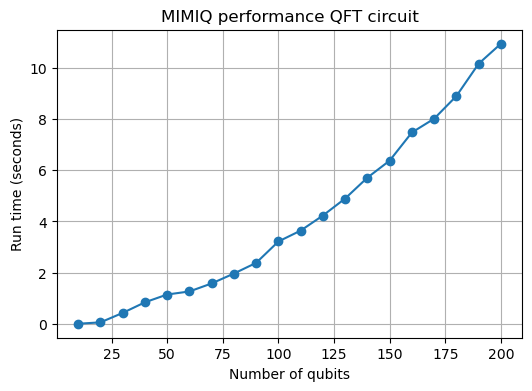

In [58]:
# extract and plot results
fid = [r.fidelities[0] for r in res]
runtime = [r.timings["total"] for r in res]

if np.isclose(np.min(fid), 1.0):
    print(f"All simulations are exact, minimum fidelity = {np.min(fid)}")
    
plt.figure(figsize=(6, 4))
plt.plot(nqubits, runtime, '-o')
plt.xlabel("Number of qubits")
plt.ylabel("Run time (seconds)")
plt.title("MIMIQ performance QFT circuit")
plt.grid(True)
plt.show()

With MIMIQ's default parameters, all simulations are effectively exact (fidelity = 1.0) and remarkably fast. Even for circuits exceeding 100 qubits, the simulations complete in just a few seconds! Although the runtime shows minor fluctuations—since we do not average over multiple runs—the overall trend is clearly quadratic in the number of qubits, rather than exponential. 

This result is particularly striking given that the QFT circuit contains approximately $N^2$ gates for $N$ qubits. The observed scaling suggests that the time required to execute each gate is essentially independent of the total number of qubits.

### Introducing the Approximate QFT

A closer look at the QFT circuit for large numbers of qubits reveals something interesting: the phase gates involve exponentially decreasing angles, $\alpha = \pi/2^x$, where $x$ ranges from 1 to $N-1$. This poses a challenge. For real quantum computers, implementing such small rotations accurately can be difficult due to hardware noise and precision limits. Similarly, for quantum emulators, these exceedingly small rotation angles drop below machine precision, potentially leading to numerical inaccuracies.

Fortunately, it is well-established that rotation gates with very small angles can often be neglected in the QFT without significantly affecting the overall fidelity [https://journals.aps.org/pra/abstract/10.1103/PhysRevA.54.139]. This aligns with our intuition: gates that are similar to the identity operation contribute minimally to the circuit's outcome. While we should be cautious, it is reasonable to assume they can be neglected.

To address this, we can define an **Approximate Quantum Fourier Transform (AQFT)**. The AQFT introduces an additional parameter, `d`, which specifies the degree of approximation. Unlike the full QFT, which includes all phase gates, the AQFT retains only those with angles $\alpha = \pi/2^x$ where $x \leq d$. Controlled phase (CP) gates with smaller angles are simply omitted, reducing circuit depth and complexity while retaining high fidelity in most cases.

We can easily implement our own AQFT using MIMIQ's gate declaration functionality. This allows us to test how varying the approximation degree impacts both simulation performance and fidelity.

In [37]:
def AQFT(n, d):
    circ = Circuit()
    q = range(n)[::-1]
    circ.push(GateH(), q[0])

    for i in range(1, n):
        for j in range(max(0, i - d),i):
            angle = np.pi / (2.0 ** (i - j))
            circ.push(GateCP(angle), q[i], q[j])

        circ.push(GateH(), q[i])
    return circ

What's the advantage of the AQFT? This operation contains significantly fewer gates, approximately $N d$, compared to the standard QFT. To obtain a good approximation, $d$ only needs to scale with $log_2(N)+2$ [https://journals.aps.org/pra/abstract/10.1103/PhysRevA.54.139]. Therefore, simulations should run much faster. Let's verify this performance improvement, again using the default parameters.

In [9]:
nsamples = 1000
nqubits = range(10, 201, 10)

circuits = []
for n in nqubits:
    d = int(np.ceil(np.log2(n)+2)) # approximation degree
    c = prepare_random_state(n)
    c.append(AQFT(n,d)) # Apply QFT to all qubits
    circuits.append(c)

In [12]:
job = conn.execute(circuits, nsamples=nsamples, algorithm='mps')
res = conn.get_results(job)

All simulations are exact, minimum fidelity = 0.9999999999526556


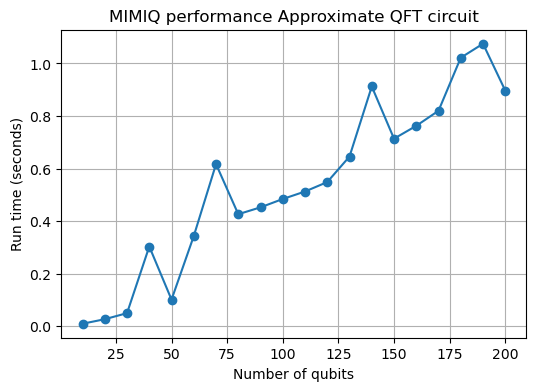

In [13]:
# extract and plot results
fid = [r.fidelities[0] for r in res]
runtime = [r.timings["total"] for r in res]

if np.isclose(np.min(fid), 1.0):
    print(f"All simulations are exact, minimum fidelity = {np.min(fid)}")
    
plt.figure(figsize=(6, 4))
plt.plot(nqubits, runtime, '-o')
plt.xlabel("Number of qubits")
plt.ylabel("Run time (seconds)")
plt.title("MIMIQ performance Approximate QFT circuit")
plt.grid(True)
plt.show()

The results demonstrate that simulating the Approximate QFT (AQFT) up to 200 qubits is approximately 10 times faster than the full QFT. Furthermore, it looks like the runtime now scales linearly with qubit number. This is a direct consequence of reducing the number of gates to be approximately proportional to $N$.

### Fidelity

How can we know if a given QFT approximation is sufficiently accurate? MIMIQ’s built-in fidelity estimator evaluates the fidelity of the target operation but does not measure how close the target operation is to an ideal one. However, in this case, we can assess the fidelity of the `AQFT` by constructing a simple test circuit: first applying a forward `QFT` followed by an `inverse(AQFT)` (or vice versa). If the approximation is good, the circuit should return the system to its initial state.

Below, we present the fidelity obtained using this method for different degrees of approximation ($d$) with $N = 100$ qubits. The fidelity values are estimated from 1,000 samples.

In [14]:
nsamples = 1000
nq = 100
dlist = range(5,20)
circuits = []
init_state = np.random.randint(2, size=nq)

for d in dlist:
    c = prepare_random_state(nq, init=init_state)
    
    # Apply QFT then inverse AQFT
    c.push(QFT(nq), *range(nq))
    c.append(inverse(AQFT(nq, d)))
    circuits.append(c)

job = conn.execute(circuits, nsamples=nsamples, algorithm='mps')
res = conn.get_results(job)

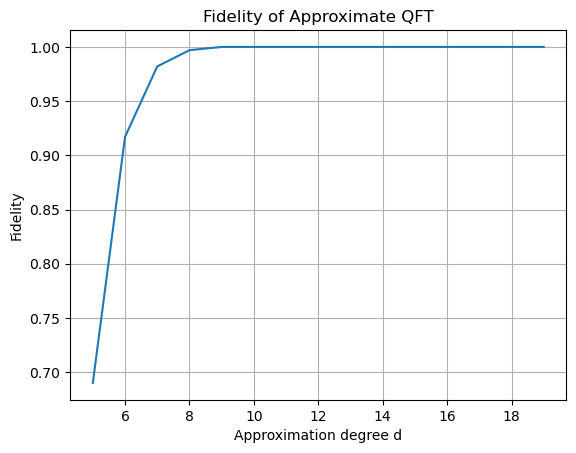

In [223]:
fids = []
for r in res:
    fids.append(np.sum([BitString(sample) == BitString(list(init_state)) for sample in r.cstates])/nsamples)
plt.plot(dlist, fids)
plt.xlabel("Approximation degree d")
plt.ylabel("Fidelity")
plt.title("Fidelity of Approximate QFT")
plt.grid(True)

We find that the AQFT achieves high fidelity for $d \geq 9$ (with $N = 100$ qubits), which corresponds to $\lceil \log_2(n) + 2 \rceil$. This result corroborates the theoretical bound mentioned earlier [https://journals.aps.org/pra/abstract/10.1103/PhysRevA.54.139], demonstrating that an excellent approximation can be obtained with relatively low approximation degree.

## Going further with MIMIQ
 So far, we have used MIMIQ's default parameters to execute the QFT. These default settings are a solid starting point when approaching a problem, as they provide a good balance between performance and fidelity. However, it is often possible to significantly enhance both runtime efficiency and accuracy by fine-tuning these parameters. In this section, we focus on the entanglement dimension (`entdim`) parameter. 

**Entanglement dimension (entdim)** plays a key role in how MIMIQ optimizes simulations. It determines the level of compression applied when combining multiple gates into a single operation, known as a Matrix Product Operator (MPO), before updating the Matrix Product State (MPS). In some cases, increasing the entdim allows for better compression, which can reduce runtimes while maintaining or even improving fidelity. 

Let’s explore how simulation performance varies with different values of the entdim parameter and examine its impact on both runtime and accuracy. 

In [224]:
nq = 500
d = 30

# generate a circuit 
circ = prepare_random_state(nq)
circ.append(AQFT(nq, d));

entdims = [4,8,16,32]
results = []
for entdim in entdims:
    job = conn.execute(circ, nsamples=nsamples, algorithm='mps', entdim=entdim)
    res = conn.get_result(job, interval=1)
    results.append(res)

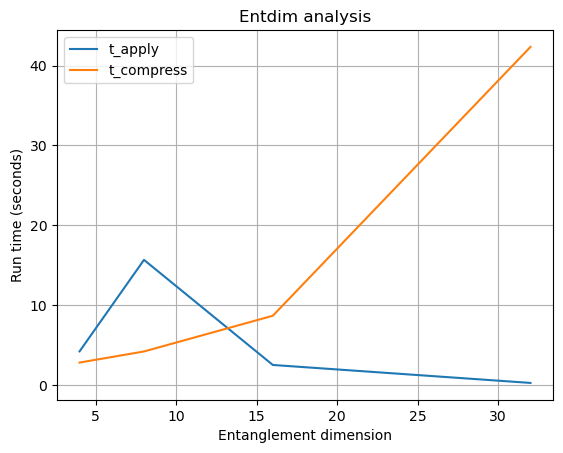

In [226]:
tapply = [r.timings['apply'] for r in results]
tcompress = [r.timings['compression'] for r in results]

plt.plot(entdims, tapply, label='t_apply')
plt.plot(entdims, tcompress, label='t_compress')
plt.xlabel("Entanglement dimension")
plt.ylabel("Run time (seconds)")
plt.title("Entdim analysis")
plt.legend()
plt.grid(True)

### Why the QFT is so simulatable

The graph above illustrates two key timing metrics in our AQFT simulation. The orange line represents the time required to compress the circuit before applying it to the Matrix Product State (MPS), while the blue line shows the actual application time. For smaller entanglement dimensions (`entdim`), both compression time (`t_compress`) and application time (`t_apply`) are comparable. However, something fascinating happens when `entdim` is increased to 32: the application time drops to nearly zero, with the majority of the computational effort shifting entirely to the compression step.

This remarkable behavior highlights a powerful capability of MIMIQ. At `entdim = 32`, the simulator successfully compresses the entire AQFT circuit into a single matrix product operator. This is connected to the fact that the QFT circuit does not generate a lot of entanglement (see https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.4.040318). In fact, it is known that the whole QFT circuit can be efficiently compressed into one matrix product operator (MPO) with low entanglement dimension.

This holds true for any number of qubits! The implications are significant: we anticipate that beyond a certain number of qubits, it becomes computationally advantageous to fully compress the AQFT circuit into a single MPO rather than applying multiple separate MPOs sequentially, and once compressed, in principle this AQFT operator can be applied to multiple initial states with almost no additional computational cost.

Interestingly, this concept has been explored recently, demonstrating that the Quantum Fourier Transform could even be used to accelerate the classical Fourier Transform under certain conditions. This is particularly noteworthy given that the classical Fourier Transform is one of the most highly optimized classical algorithms ever developed. For more details, see [Superfast Fourier Transform](https://link.springer.com/article/10.1007/s00041-012-9227-4).

### Large scale simulations, beyond 1000 qubits

As a final demonstration we will run the AQFT circuit for different numbers of qubits up to a maximum of 4096.

In [38]:
nsamples = 1
nqubits = [64,128,256,512,1024,2048,4096]
d = 30
circuits = []
for nq in nqubits:
    c = prepare_random_state(nq)
    c.append(AQFT(nq,d)) # Apply QFT to all qubits
    circuits.append(c)

In [ ]:
# entdim =4
jobs4 = []
for c in circuits:
    j = conn.execute(c, nsamples=nsamples, algorithm='mps', entdim=4, bonddim=8)
    jobs4.append(j)
    
# entdim = 32
jobs32 = []
for c in circuits:
    j = conn.execute(c, nsamples=nsamples, algorithm='mps', entdim=32, bonddim=8)
    jobs32.append(j)

In [52]:
# retrieve all jobs
res4, res32 = [], []
for job in jobs4:
    if conn.isJobDone(job):
        res4.append(conn.get_result(job))
for job in jobs32:
    if conn.isJobDone(job):
        res32.append(conn.get_result(job))

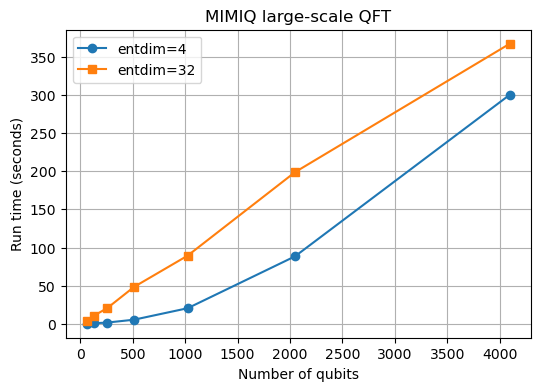

In [54]:
# extract and plot results
runtime4 = [r.timings["total"] for r in res4]
runtime32 = [r.timings["total"] for r in res32]

plt.figure(figsize=(6, 4))
plt.plot(nqubits[:len(runtime4)], runtime4, '-o', label='entdim=4')
plt.plot(nqubits[:len(runtime32)], runtime32, '-s', label='entdim=32')
plt.xlabel("Number of qubits")
plt.ylabel("Run time (seconds)")
plt.title("MIMIQ large-scale QFT")
plt.grid(True)
plt.legend()
plt.show()

## Conclusions

In this demo, we’ve highlighted MIMIQ’s impressive capability to simulate the Quantum Fourier Transform (QFT), reaching beyond 4000 qubits. This underscores the power and versatility of matrix product states for simulating important quantum algorithms at unprecedented scales.

In the process we’ve found some key insights:

- **The uniqueness of MIMIQ’s emulator:** The performance of a quantum emulator depends on not only the state representation (MPS), but also how we construct the operations and apply them. In MIMIQ we have a highly optimized method to compress quantum algorithms using matrix product operators (MPO's). This unique feature is critical for achieving the exceptional performance of our MPS-based simulations.
- **Optimization matters:** Fine-tuning parameters such as bond dimension and entanglement dimension can have a profound impact on performance. We demonstrated how these optimizations enable simulations far beyond traditional scales and we encourage users to adopt similar analyses for their own algorithms.
- **Open questions:** For experts, this demo might raise a few intriguing questions: 1) We have only explored simple (non-entangled) initial states so far. How does the QFT affect entanglement for a general entangled state (e.g., one with fixed bond dimensions)? 2) Why does one implementation (entdim=4) scale quadratically at large $N$, while another (entdim=32) scales almost linearly?

Finally, we encourage you to explore further. Are there other algorithms or primitives that compress as effectively as QFT? We believe there’s significant potential for discovery here.